In [26]:
import numpy as np
import pandas as pd


from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from psql_functions import execQuery
from miss_data import add_missing_dates, add_missing_counts
from make_plots import dict_error_plot_epsilons, dict_error_plot_n
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import re
owd = os.getcwd()

In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

query = """select count_ from _775147;"""
result = execQuery(param_dic, query)

counts = [(count[0]) for count in result]

all_dates = add_missing_dates(dates)
all_counts =  add_missing_counts(counts, dates, all_dates)



Executed query and closed connection.
Executed query and closed connection.


# Variabels

In [3]:
epsilons = np.array([2, 1.4, 1.2, 1, 0.8, 0.6, 0.4, 0.2])
n = np.array([32, 128, 256, 512, 1024, 2048])
degrees = np.array([2,3,4])

n_data_structures = 50

In [4]:
onlydirs = [f for f in os.listdir(os.getcwd()) if os.path.isdir(os.path.join(os.getcwd(), f)) and f[0] != '.']

In [5]:
onlydirs

['Data', 'plots', 'range_queries', 'results', '__pycache__']

In [6]:
def make_results_lookup_dict_n(epsilons, n):
    epsilon_dict = dict.fromkeys(epsilons)
    n_dicts = []

    for e_key in epsilon_dict:
        #print(e_key)
        epsilon_dict[e_key] = dict.fromkeys(n)
        n_dict = epsilon_dict[e_key]
        #print(epsilon_dict[e_key])
        for n_key in n_dict:
            n_dict[n_key] = dict.fromkeys(degrees)
    return epsilon_dict

def fill_up_results_lookup_dict_n(epsilons, n, path, files):
    dict_ = make_results_lookup_dict_n(epsilons, n)
    for idx, f in enumerate(files):
        e = re.search(r'e=[-+]?[0-9]*\.?[0-9]*', f).group(0)
        e = e.split("e=")[1]
        N = re.search(r'N=\d+', f).group(0)
        N = N.split("N=")[1]

        dict_[float(e)][int(N)] = np.loadtxt(path + f, delimiter=',')
    return dict_

In [7]:
def make_lookup_results_dict_n_degree(epsilons, n, degrees):
    epsilon_dict = dict.fromkeys(epsilons)
    n_dicts = []
    for i in range(0,len(epsilons)):
        n_dict = dict.fromkeys(n)
        n_dicts.append(n_dict)
    degree_dicts = []
    for i in range(0,len(n)*len(epsilons)):
        degree_dict = dict.fromkeys(degrees)

        degree_dicts.append(degree_dict)
    i = 0
    j = 0
    for e_key in epsilon_dict:
        #print(e_key)
        epsilon_dict[e_key] = dict.fromkeys(n)
        n_dict = epsilon_dict[e_key]
        #print(epsilon_dict[e_key])
        for n_key in n_dict:
            n_dict[n_key] = dict.fromkeys(degrees)
            j = j + 1
        i = i + 1
        #print(epsilon_dict)
    return epsilon_dict


def fill_up_lookup_results_dict_n_degree(epsilons, n, degrees, path, files):
    dict_ = make_lookup_results_dict_n_degree(epsilons, n, degrees)
    for idx, f in enumerate(files):
        e = re.search(r'e=[-+]?[0-9]*\.?[0-9]*', f).group(0)
        e = e.split("e=")[1]
        here_n = re.search(r'N=\d+', f).group(0)
        here_n = here_n.split("N=")[1]
        here_degree = re.search(r'B=\d+', f).group(0) 
        here_degree = here_degree.split("B=")[1]

        dict_[float(e)][int(here_n)][int(here_degree)] = np.loadtxt(path + f, delimiter=',')
    return dict_

def find_error_different_queries(est, cor):
    erorrs = est - cor
    max_error = np.amax(erorrs)
    min_error = np.amin(erorrs)
    rmse = mean_squared_error(cor, est, squared = False)
    error_dict = {'rmse': rmse, 'max': max_error, 'min': min_error, 'abs': np.mean(erorrs)}
    return error_dict

In [8]:
def load_split_est_n_cor_files(path):
    files_cor = [f for f in os.listdir(path) if re.match(r'(cor).*\.csv', f)]
    files_est = [f for f in os.listdir(path) if re.match(r'(est).*\.csv', f)]

    #Where flat beats hh
    cor_flat_better = [f for f in files_cor if re.match(r'.*(_flat_).*\.csv', f)]
    #Where hh beats flat
    cor_hh_better = flat_files_cor = [f for f in files_cor if re.match(r'.*(_hh_).*\.csv', f)]

    #Where flat beats hh
    est_flat_better =  [f for f in files_est if re.match(r'.*(_flat_).*\.csv', f)]
    #Where hh beats flat
    est_hh_better = [f for f in files_est if re.match(r'.*(_hh_).*\.csv', f)]
    
    return est_flat_better, cor_flat_better, est_hh_better, cor_hh_better

# Loading the data from the hierarchical Histogram model

In [9]:
path = owd + '/results/sample_querys/local_hh/'

hh_files_est_flat, hh_files_cor_flat, hh_files_est_hh, hh_files_cor_hh = load_split_est_n_cor_files(path)

In [10]:
hh_cor_flat_dict = fill_up_lookup_results_dict_n_degree(epsilons, n, degrees, path, hh_files_cor_flat)
hh_cor_hh_dict = fill_up_lookup_results_dict_n_degree(epsilons, n, degrees, path, hh_files_cor_hh)

hh_est_flat_dict = fill_up_lookup_results_dict_n_degree(epsilons, n, degrees, path, hh_files_est_flat)
hh_est_hh_dict = fill_up_lookup_results_dict_n_degree(epsilons, n, degrees, path, hh_files_est_hh)

In [11]:
hh_cor_flat_dict

{2.0: {32: {2: array([1066., 1273.,  957., ..., 1247., 1008., 1077.]),
   3: array([1066., 1273.,  957., ..., 1247., 1008., 1077.]),
   4: array([1066., 1273.,  957., ..., 1247., 1008., 1077.])},
  128: {2: array([1042., 2217., 1906., ..., 2340., 2338., 1931.]),
   3: array([1042., 2217., 1906., ..., 2340., 2338., 1931.]),
   4: array([1042., 2217., 1906., ..., 2340., 2338., 1931.])},
  256: {2: array([4009., 3845., 4497., ..., 4145., 3983., 3417.]),
   3: array([4009., 3845., 4497., ..., 4145., 3983., 3417.]),
   4: array([4009., 3845., 4497., ..., 4145., 3983., 3417.])},
  512: {2: array([7332., 7058., 9128., ..., 9877., 7308., 9083.]),
   3: array([7332., 7058., 9128., ..., 9877., 7308., 9083.]),
   4: array([7332., 7058., 9128., ..., 9877., 7308., 9083.])},
  1024: {2: array([ 9144.,  8803.,  9561., ..., 10498.,  9862.,  5846.]),
   3: array([ 9144.,  8803.,  9561., ..., 10498.,  9862.,  5846.]),
   4: array([ 9144.,  8803.,  9561., ..., 10498.,  9862.,  5846.])},
  2048: {2: array

# Loading the data from the flat model

In [12]:
path = owd + '/results/sample_querys/flat/'

flat_files_est_flat, flat_files_cor_flat, flat_files_est_hh, flat_files_cor_hh = load_split_est_n_cor_files(path)

In [13]:
flat_cor_flat_dict = fill_up_results_lookup_dict_n(epsilons, n, path, flat_files_cor_flat)
flat_cor_hh_dict = fill_up_lookup_results_dict_n_degree(epsilons, n, degrees, path, flat_files_cor_hh)

flat_est_flat_dict = fill_up_results_lookup_dict_n(epsilons, n, path, flat_files_est_flat)
flat_est_hh_dict = fill_up_lookup_results_dict_n_degree(epsilons, n, degrees, path, flat_files_est_hh)

In [14]:
def make_flat_errors_dict(epsilons, n, degrees):
    epsilon_dict = dict.fromkeys(epsilons)
    
    n_dicts = []
    for i in range(0,len(epsilons)):
        n_dict = dict.fromkeys(n)
        n_dicts.append(n_dict)
    
    model_dicts = []
    for i in range(0,len(n)*len(epsilons)):
        model_dict = dict.fromkeys(['flat', 'hh'])

        model_dicts.append(model_dict)
    
    degree_dicts = []
    for i in range(0,len(n)*len(epsilons)):
        degree_dict = dict.fromkeys(degrees)
        degree_dicts.append(degree_dict)
    
    i = 0
    j = 0
    for e_key in epsilon_dict:
        #print(e_key)
        epsilon_dict[e_key] = n_dicts[i]
        n_dict = epsilon_dict[e_key]
        #print(epsilon_dict[e_key])
        for n_key in n_dict:
            n_dict[n_key] = model_dicts[j]
            n_dict[n_key]['hh'] = degree_dicts[j]
            j = j + 1
        i = i + 1
        #print(epsilon_dict)
    return epsilon_dict

def fill_up_flat_errors_dict(epsilons, n, degrees, flat_est_dict, flat_cor_dict, hh_est_dict, hh_cor_dict):
    dict_ = make_flat_errors_dict(epsilons, n, degrees)
    for e in epsilons:
        for N in n:

            flat_cor = flat_cor_dict[e][N]
            flat_est = flat_est_dict[e][N]
            dict_[e][N]['flat'] = find_error_different_queries(flat_est, flat_cor) 

            for degree in degrees:

                hh_cor = hh_cor_dict[e][N][degree]
                hh_est = hh_est_dict[e][N][degree]
                hh_rmse = find_error_different_queries(hh_est, hh_cor)

                dict_[e][N]['hh'][degree] = find_error_different_queries(hh_est, hh_cor)
    return dict_

In [15]:
def make_hh_errors_dict(epsilons, n, degrees):
    epsilon_dict = dict.fromkeys(epsilons)
    
    n_dicts = []
    for i in range(0,len(epsilons)):
        n_dict = dict.fromkeys(n)
        n_dicts.append(n_dict)
    
    model_dicts = []
    for i in range(0,len(n)*len(epsilons)):
        model_dict = dict.fromkeys(['flat', 'hh'])

        model_dicts.append(model_dict)
    
    degree_dicts = []
    for i in range(0,len(n)*len(epsilons)):
        degree_dict = dict.fromkeys(degrees)
        degree_dicts.append(degree_dict)
    
    i = 0
    j = 0
    for e_key in epsilon_dict:
        #print(e_key)
        epsilon_dict[e_key] = n_dicts[i]
        n_dict = epsilon_dict[e_key]
        #print(epsilon_dict[e_key])
        for n_key in n_dict:
            n_dict[n_key] = model_dicts[j]
            n_dict[n_key]['flat'] = dict.fromkeys(degrees)
            n_dict[n_key]['hh'] = dict.fromkeys(degrees)
            j = j + 1
        i = i + 1
        #print(epsilon_dict)
    return epsilon_dict

def fill_up_hh_errors_dict(epsilons, n, degrees, flat_est_dict, flat_cor_dict, hh_est_dict, hh_cor_dict):
    dict_ = make_hh_errors_dict(epsilons, n, degrees)
    for e in epsilons:
        for N in n:
            for degree in degrees:

                flat_cor = flat_cor_dict[e][N][degree]
                flat_est = flat_est_dict[e][N][degree]

                hh_cor = hh_cor_dict[e][N][degree]
                hh_est = hh_est_dict[e][N][degree]

                if len(flat_est) !=0 or len(flat_cor) !=0 or  len(hh_est) !=0 or  len(hh_cor) !=0 :

                    dict_[e][N]['flat'][degree] = find_error_different_queries(flat_est, flat_cor) 
                    dict_[e][N]['hh'][degree] = find_error_different_queries(hh_est, hh_cor)
                    
    return dict_

In [16]:
flat_error_dict = fill_up_flat_errors_dict(epsilons, n, degrees, flat_est_flat_dict, flat_cor_flat_dict, hh_est_flat_dict, hh_cor_flat_dict)
flat_error_dict


{2.0: {32: {'flat': {'rmse': 147.156419020598,
    'max': 452.91395938796177,
    'min': -540.9010507145824,
    'abs': 5.909452346571899},
   'hh': {2: {'rmse': 260.333156483884,
     'max': 836.1895610503484,
     'min': -1003.3600907494707,
     'abs': -3.668602823529264},
    3: {'rmse': 393.4920682615496,
     'max': 1508.1026414336538,
     'min': -1539.057077077286,
     'abs': -0.5817328980573268},
    4: {'rmse': 342.260102910508,
     'max': 1137.332726122721,
     'min': -987.5016052789081,
     'abs': -40.472278022905634}}},
  128: {'flat': {'rmse': 787.4035508123478,
    'max': 2698.9651080073927,
    'min': -2521.931430291857,
    'abs': 10.903752741479977},
   'hh': {2: {'rmse': 999.1236861313329,
     'max': 4219.10867148692,
     'min': -3592.5439095978877,
     'abs': -17.35296371388003},
    3: {'rmse': 1400.6153661044832,
     'max': 5189.479659022669,
     'min': -5103.483658762848,
     'abs': -73.60993277125525},
    4: {'rmse': 1488.1237586295033,
     'max': 59

In [17]:
hh_error_dict = fill_up_hh_errors_dict(epsilons, n, degrees, flat_est_hh_dict, flat_cor_hh_dict, hh_est_hh_dict, hh_cor_hh_dict)
hh_error_dict

{2.0: {32: {'flat': {2: None, 3: None, 4: None},
   'hh': {2: None, 3: None, 4: None}},
  128: {'flat': {2: None, 3: None, 4: None},
   'hh': {2: None, 3: None, 4: None}},
  256: {'flat': {2: {'rmse': 3180.6315414083992,
     'max': 10086.509389504787,
     'min': -7661.8298313752175,
     'abs': -121.6680131927262},
    3: {'rmse': 2580.478068804104,
     'max': 6833.196682823422,
     'min': -7245.750273902966,
     'abs': -543.0562154346284},
    4: {'rmse': 3684.674721177761,
     'max': 9101.044196039453,
     'min': -9801.288394431329,
     'abs': -972.944533893945}},
   'hh': {2: {'rmse': 2129.7819406878884,
     'max': 9004.09269779532,
     'min': -7645.816234173851,
     'abs': -22.877068161443812},
    3: {'rmse': 3861.3962062135693,
     'max': 11323.877839474357,
     'min': -12863.047955040667,
     'abs': 114.76705769847075},
    4: {'rmse': 2332.1548598032,
     'max': 7703.992847567744,
     'min': -7668.620147101614,
     'abs': -257.55476613524945}}},
  512: {'flat':

In [18]:
def same_parameter(answers, correct_answer):
    error = np.abs(correct_answer-answers)
    max_error = np.amax(error)
    min_error = np.amin(error)
    true_values = np.full(len(answers), correct_answer)
    mse = mean_squared_error(true_values, answers, squared = False)
    error_dict = {'mse': mse, 'max': max_error, 'min': min_error, 'abs': np.mean(error)}
    
    return error_dict


0.9907218149746239
0.8935229178772973
0.8614148105590437


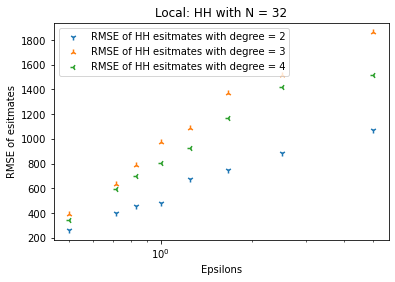

0.9792276370086652
0.8452467929958234
0.8751669816946311


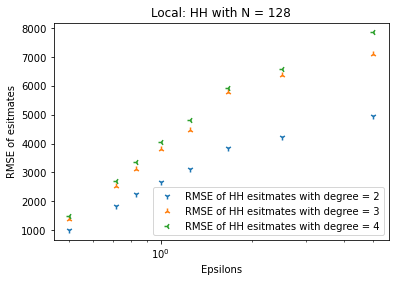

0.9875530742896744
0.8815744177945681
0.865926164577854


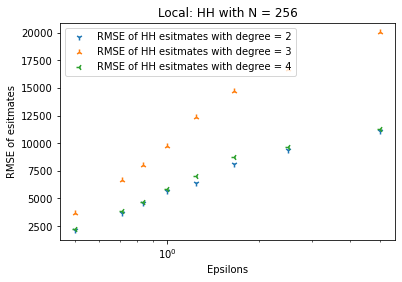

0.9817171310069852
0.8803496687940756
0.879539748483193


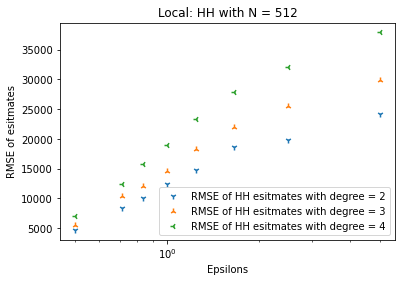

0.9821909712870993
0.8836401596333463
0.8899807408743374


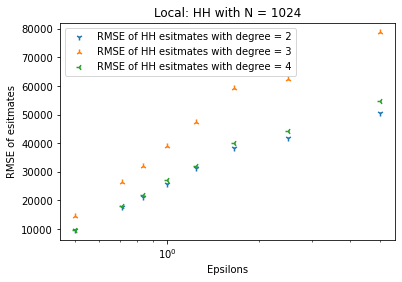

0.9848178556059175
0.8988065064287654
0.8824676815949382


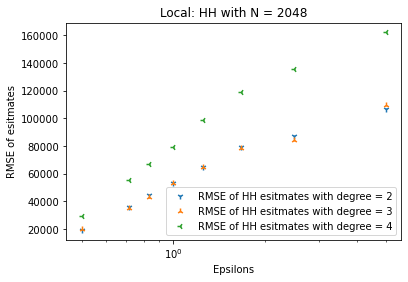

In [61]:
def flat_better_plots(epsilons, n, degrees, flat_error_dict, path):
    for N in n:
        rmse_flat = []
        rmse_degree2 = []
        rmse_degree3 = []
        rmse_degree4 = []

        for e in epsilons:


            #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
            #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])

            #plt.savefig(plot_name,dpi=300,bbox_inches='tight')
            rmse = flat_error_dict[e][N]['flat']['rmse']
            rmse_flat.append(rmse)
            #plt.scatter(e, rmse, marker = '+', label=f"RMSE of flat esitmates with \u03B5 = {e}")

            for idx, degree in enumerate(flat_error_dict[e][N]['hh']):
                #print(flat_error_dict[e][N]['hh'][degree]['rmse'])
                rmse = flat_error_dict[e][N]['hh'][degree]['rmse']
                if degree == 2:
                    rmse_degree2.append(rmse)
                if degree == 3:
                    rmse_degree3.append(rmse)
                if degree == 4:
                    rmse_degree4.append(rmse)

                #plt.scatter(e, rmse, marker = 'o', label=f"RMSE of HH esitmates with degree = {degree} and \u03B5 = {e}")
        #plt.scatter(epsilons, rmse_flat, marker = '+', label=f"RMSE of flat esitmates")
        ys1 = rmse_degree2
        xs = np.log(1/epsilons)
        gradient, intercept, r_value, p_value, std_err = stats.linregress(xs,ys1)
        mn=np.min(xs)
        mx=np.max(xs)
        x1=np.linspace(mn,mx,500)
        y1=gradient*x1+intercept
        print(r_value)
        #plt.plot(x,y,'ob')
        #plt.plot(x1,y1,'--')
        
        ys1 = rmse_degree3
        xs = 1/epsilons
        gradient, intercept, r_value, p_value, std_err = stats.linregress(xs,ys1)
        mn=np.min(xs)
        mx=np.max(xs)
        x1=np.linspace(mn,mx,500)
        y1=gradient*x1+intercept
        print(r_value)
        #plt.plot(x,y,'ob')
        #plt.plot(x1,y1,'--')
        ys1 = rmse_degree4
        xs = 1/epsilons
        gradient, intercept, r_value, p_value, std_err = stats.linregress(xs,ys1)
        mn=np.min(xs)
        mx=np.max(xs)
        x1=np.linspace(mn,mx,500)
        y1=gradient*x1+intercept
        print(r_value)
        #plt.plot(x,y,'ob')
        #plt.plot(x1,y1,'--')
        
        plt.scatter(1/epsilons, rmse_degree2, marker = '1', label=f"RMSE of HH esitmates with degree = {2}")
        plt.scatter(1/epsilons, rmse_degree3, marker = '2', label=f"RMSE of HH esitmates with degree = {3}")
        plt.scatter(1/epsilons, rmse_degree4, marker = '3', label=f"RMSE of HH esitmates with degree = {4}")

        plt.xscale('log')
        #plt.yscale('log')

        plt.legend()
        plt.xlabel('Epsilons')
        plt.ylabel('RMSE of esitmates')
        plt.title(f'Local: HH with N = {N}')
        plt_name = f'hh_lin_N={N}'
        plt.savefig(owd + path + plt_name, bbox_inches='tight')
        plt.show()

path = '/plots/local/epsilon/'
flat_better_plots(epsilons[:], n, degrees, flat_error_dict, path)

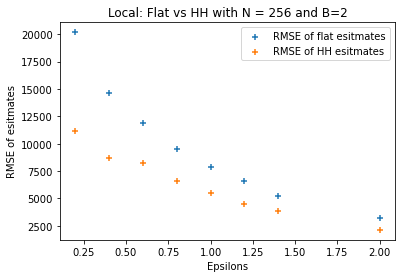

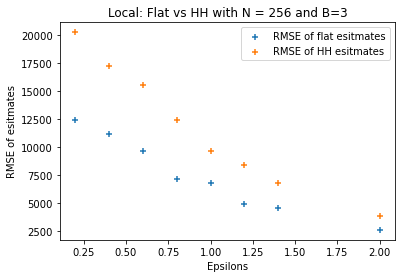

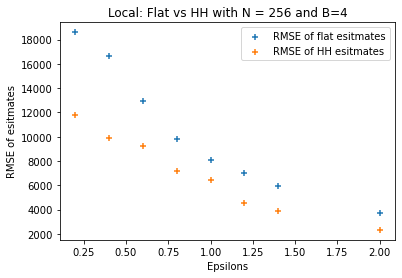

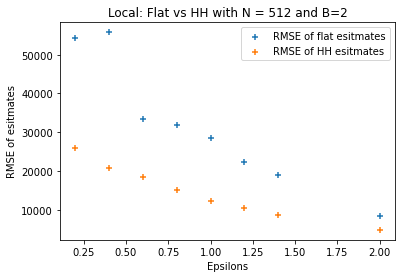

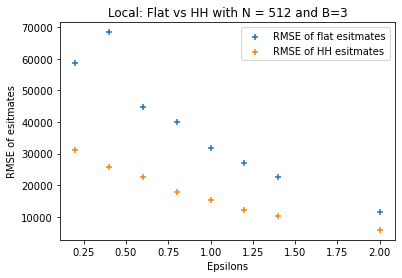

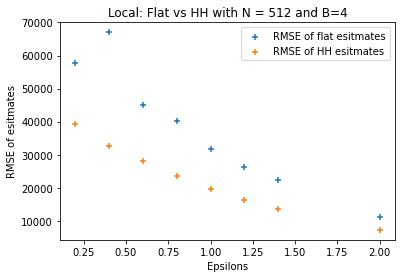

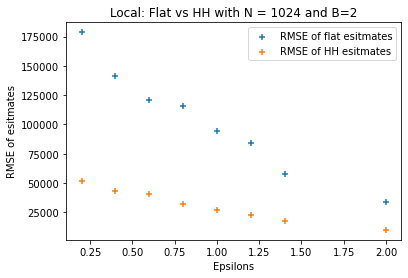

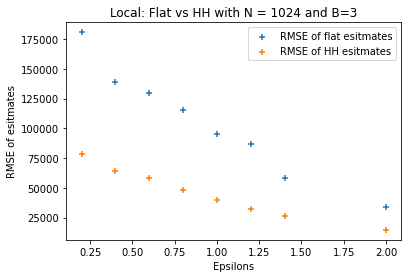

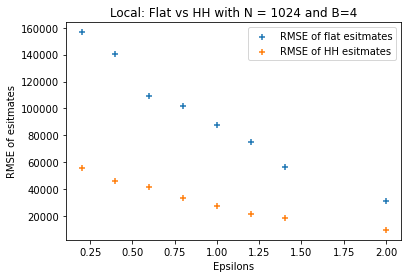

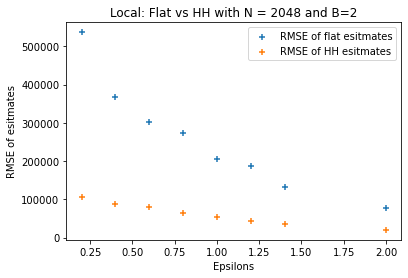

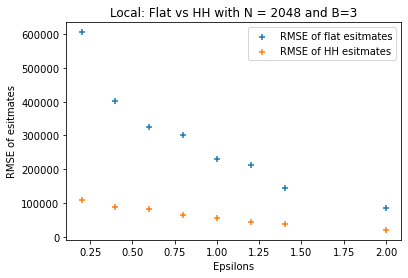

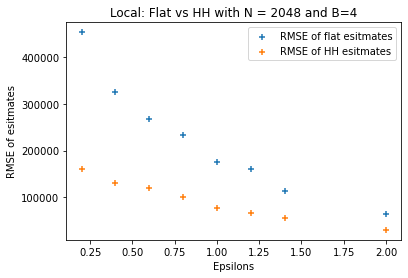

In [20]:
def hh_better_plots(epsilons, n, degrees, hh_error_dict, path):
    for N in n:
        rmse_flat_2 = []
        rmse_flat_3 = []
        rmse_flat_4 = []
        rmse_degree2 = []
        rmse_degree3 = []
        rmse_degree4 = []

        for e in epsilons:


            #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
            #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])

            #plt.savefig(plot_name,dpi=300,bbox_inches='tight')
            #rmse = flat_error_dict[e][N]['flat']['rmse']
            #rmse_flat.append(rmse)
            #plt.scatter(e, rmse, marker = '+', label=f"RMSE of flat esitmates with \u03B5 = {e}")
            for idx, degree in enumerate(hh_error_dict[e][N]['hh']):
                #print(flat_error_dict[e][N]['hh'][degree]['rmse'])
                rmse = hh_error_dict[e][N]['flat'][degree]['rmse']
                if degree == 2:
                    rmse_flat_2.append(rmse)
                if degree == 3:
                    rmse_flat_3.append(rmse)
                if degree == 4:
                    rmse_flat_4.append(rmse)
            for idx, degree in enumerate(hh_error_dict[e][N]['hh']):
                #print(flat_error_dict[e][N]['hh'][degree]['rmse'])
                rmse = hh_error_dict[e][N]['hh'][degree]['rmse']
                if degree == 2:
                    rmse_degree2.append(rmse)
                if degree == 3:
                    rmse_degree3.append(rmse)
                if degree == 4:
                    rmse_degree4.append(rmse)

                #plt.scatter(e, rmse, marker = 'o', label=f"RMSE of HH esitmates with degree = {degree} and \u03B5 = {e}")
        
        plt.scatter(epsilons, rmse_flat_2, marker = '+', label=f"RMSE of flat esitmates")
        plt.scatter(epsilons, rmse_degree2, marker = '+', label=f"RMSE of HH esitmates")
        
        #plt.yscale('log')
        plt.legend()
        plt.xlabel('Epsilons')
        plt.ylabel('RMSE of esitmates')
        plt.title(f'Local: Flat vs HH with N = {N} and B=2')
        plt_name = f'hh_beat_flat={N}_B=2'
        plt.savefig(owd + path + plt_name, bbox_inches='tight')
        plt.show()
        plt.scatter(epsilons, rmse_flat_3, marker = '+', label=f"RMSE of flat esitmates")
        plt.scatter(epsilons, rmse_degree3, marker = '+', label=f"RMSE of HH esitmates")
        
        #plt.yscale('log')
        plt.legend()
        plt.xlabel('Epsilons')
        plt.ylabel('RMSE of esitmates')
        plt.title(f'Local: Flat vs HH with N = {N} and B=3')
        plt_name = f'hh_beat_flat={N}_B=3'
        plt.savefig(owd + path + plt_name, bbox_inches='tight')
        plt.show()
        
        plt.scatter(epsilons, rmse_flat_4, marker = '+', label=f"RMSE of flat esitmates")
        plt.scatter(epsilons, rmse_degree4, marker = '+', label=f"RMSE of HH esitmates")
        #plt.yscale('log')
        plt.legend()
        plt.xlabel('Epsilons')
        plt.ylabel('RMSE of esitmates')
        plt.title(f'Local: Flat vs HH with N = {N} and B=4')
        plt_name = f'hh_beat_flat={N}_B=4'
        plt.savefig(owd + path + plt_name, bbox_inches='tight')
        plt.show()

        
path = '/plots/local/hh_beat_flat/'
hh_better_plots(epsilons, n[2:], degrees, hh_error_dict, path)

In [21]:
def multi_e_plots(epsilons, n, error_dict, path):
    for N in n:
        rmse_lst = []
        
        for e in epsilons:

            for r_ in error_dict[e][N]:
                rmse = error_dict[e][N][r_]['rmse']
                rmse_lst.append(rmse)
        #print(rmse_lst)
        
        for i in range(len(error_dict[e][N])):
            #print(i)
            #print(list(error_dict[e][N].keys()))
            #print(rmse_lst[i*len(error_dict[e][N]):(i+1)*len(error_dict[e][N])])
            ys = rmse_lst[i*len(error_dict[e][N]):(i+1)*len(error_dict[e][N])]
            xs = list(error_dict[e][N].keys())
            
            mymodel = np.poly1d(np.polyfit(xs, ys, 2))
            mn=np.min(xs)
            mx=np.max(xs)
            x1=np.linspace(mn,mx,500)
            plt.plot(x1, mymodel(x1))

            #plt.scatter(x1, y)
            """
            gradient, intercept, r_value, p_value, std_err = stats.linregress(xs,ys)
            mn=np.min(xs)
            mx=np.max(xs)
            x1=np.linspace(mn,mx,500)
            y1=gradient*x1+intercept
            print(r_value)
            #plt.plot(x,y,'ob')
            plt.plot(x1,y1,'--')
            """
            """
            """
            plt.scatter(xs, ys, marker = '+', label=f"{epsilons[i]}")
        #plt.scatter(epsilons, rmse_degree2, marker = '+', label=f"RMSE of HH esitmates")
        
        #plt.yscale('log')
        plt.legend()
        plt.xlabel('Lenght of query')
        plt.ylabel('RMSE of esitmates')
        plt_name = f'loc_flat_varying_length_N_poly_={N}'
        plt.title(f'Local flat with varying length of queries. With N = {N}')
        #plt.savefig(owd + path + plt_name, bbox_inches='tight')
        plt.show()

#path = '/plots/local_flat/varying_r/'
multi_e_plots(epsilons, n, hh_error_dict, path)
    
    

KeyError: 'rmse'

In [ ]:
x = np.arange(0, len(hh_rmse_hh))
plt.scatter(x, flat_rmse_hh, marker = '+', label="Flat rmse")
plt.scatter(x, hh_rmse_hh, marker = 'o', label="HH rmse")
plt.plot()

In [ ]:
epsilon_error_dicts = {}
for idx, e in enumerate(epsilons):
    epsilon_error_dicts[e] = same_parameter(epsilons_res[idx], correct_answer)

In [ ]:
epsilon_error_dicts

In [ ]:
plt_name = 'flat_freq_epsilon'
dict_error_plot_epsilons(epsilon_error_dicts,plt_name, epsilons)

In [ ]:
n_error_dicts = {}
for idx, N in enumerate(n):
    n_error_dicts[N] = same_parameter(ns[idx], correct_answer)



In [ ]:
n_error_dicts

In [ ]:
print(n)
plt_name = 'flat_freq_N'
dict_error_plot_n(n_error_dicts,plt_name, n)